## **Lung Cancer Image Classification**

### **A. Introduction**

- **Name**  : Livia Amanda Annafiah
- **Dataset** : [Lung Cancer Dataset](https://www.kaggle.com/datasets/adityamahimkar/iqothnccd-lung-cancer-dataset/data)
- **Hugging Face**: [Link](https://huggingface.co/spaces/liviamanda/LungCancerPrediction)

---------------------

**Problem Statement**

The hospital faces a major difficulty in accurately diagnosing lung conditions from patient X-ray images. Specifically, it is difficult to predict whether a patient has a malignant, benign, or normal lung case based solely on the X-ray images. This diagnostic uncertainty can lead to delays in treatment, increased patient anxiety, and potentially inappropriate medical interventions. Addressing this issue is crucial to improving patient outcomes and ensuring timely and accurate diagnosis of lung conditions.

The dataset for this analysis focuses on X-ray images of patients' lungs with various conditions.

**Objective**

The goal of this project is to create a `Convolutional Neural Network (CNN)` model that accurately predicts lung conditions from X-ray images. It will distinguish between malignant, benign, and normal cases, primarily using `accuracy` as the evaluation metric. This aims to improve diagnostics, patient outcomes, and reduce uncertainties in clinical settings through advanced **computer vision** techniques.

### **B. Libraries**

The libraries used to develop the model are as follows:

In [1]:
# Import libraries for data loading
from google.colab import drive
from PIL import Image
import zipfile
import os

# Import libraries for data operations
import numpy as np
import pandas as pd
import cv2
import math

# Import libraries for data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Import libraries for feature engineering
from sklearn.model_selection import train_test_split
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator

# Import libraries for model creation
from keras.models import Sequential, Model
from keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, Concatenate

# Import libraries for model training
from sklearn.utils import class_weight
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

# Import libraries for model evaluation
from sklearn.metrics import confusion_matrix, classification_report

# Import libraries for pre-trained model
from tensorflow.keras.applications.xception import Xception

# Import libraries for warning management
import warnings
warnings.filterwarnings('ignore')

### **C. Data Loading**

In this initial stage, the data is loaded and a dataframe is created to simplify further analysis.

The images are sourced from Kaggle, downloaded, and then uploaded to Google Drive. Therefore, the first step is to mount Google Drive to connect it with Google Colab.

In [2]:
# Connect to google drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


With Google Drive successfully mounted, the next step is to define the paths to each folder and specify the classes for the images. This setup is essential for organizing the data and ensuring efficient access during model training and evaluation.

In [3]:
# Define train and test path
raw_data_training_path = '/content/drive/MyDrive/Hacktive8/P2G7/Training'

# Define classes
classes = ["Benign cases", "Malignant cases", "Normal cases"]

# Check if the extraction directory exists, if not, create it
if not os.path.exists(raw_data_training_path):
  for class_list in classes:
    os.makedirs(os.path.join(raw_data_training_path, class_list))
    print(f"Extraction directory '{raw_data_training_path}/{class_list}' created.")

The new folders on Google Drive, namely `Training` have been successfully created. The next step involves putting the images into the training path. The training folder will contain subfolders named `Benign cases`, `Malignant cases`, and `Normal cases`. For now, the main dataset is stored in the `Training` folder and haven't been splitted yet.

In [4]:
# Define the paths for each case type
normal_cases_path = os.path.join(raw_data_training_path, 'Normal cases')
benign_cases_path = os.path.join(raw_data_training_path, 'Benign cases')
malignant_cases_path = os.path.join(raw_data_training_path, 'Malignant cases')

# Function to list files in a directory
def list_files(directory_path):
    return os.listdir(directory_path)

# List files in each directory
print("Paths to dataset folder:")
print("Dataset Path:", raw_data_training_path)

print("\nFiles in each folder:")
print("Normal Cases:", list_files(normal_cases_path))
print("Benign Cases:", list_files(benign_cases_path))
print("Malignant Cases:", list_files(malignant_cases_path))

Paths to dataset folder:
Dataset Path: /content/drive/MyDrive/Hacktive8/P2G7/Training

Files in each folder:
Normal Cases: ['Normal case (104).jpg', 'Normal case (11).jpg', 'Normal case (1).jpg', 'Normal case (102).jpg', 'Normal case (111).jpg', 'Normal case (105).jpg', 'Normal case (10).jpg', 'Normal case (108).jpg', 'Normal case (110).jpg', 'Normal case (103).jpg', 'Normal case (109).jpg', 'Normal case (101).jpg', 'Normal case (107).jpg', 'Normal case (106).jpg', 'Normal case (100).jpg', 'Normal case (135).jpg', 'Normal case (119).jpg', 'Normal case (133).jpg', 'Normal case (118).jpg', 'Normal case (138).jpg', 'Normal case (124).jpg', 'Normal case (113).jpg', 'Normal case (114).jpg', 'Normal case (131).jpg', 'Normal case (134).jpg', 'Normal case (112).jpg', 'Normal case (13).jpg', 'Normal case (122).jpg', 'Normal case (12).jpg', 'Normal case (125).jpg', 'Normal case (139).jpg', 'Normal case (126).jpg', 'Normal case (116).jpg', 'Normal case (120).jpg', 'Normal case (123).jpg', 'Normal

The images are now in the `Training` folder. Next, the total number of images in each folder will be counted to determine their quantities.

In [5]:
# Function to count files in a folder
def count_files(folder_path):
    file_list = os.listdir(folder_path)
    return len(file_list)

# Create a dictionary with case names and counts
cases_dict = {'Benign Case': count_files(benign_cases_path),
              'Normal Case': count_files(normal_cases_path),
              'Malignant Case': count_files(malignant_cases_path)}

# Create a DataFrame from the dictionary
cases_df = pd.DataFrame.from_dict(cases_dict, orient='index', columns=['Number of Images'])

# Display the DataFrame
cases_df

Number of Images
Benign Case                  120
Normal Case                  416
Malignant Case               561

The count indicates **120** images for Benign cases, **416** for Normal cases, and **561** for Malignant cases. This distribution shows a higher number of Malignant cases compared to Benign cases.

Finally, a dataframe containing the file paths and their classes will be created to simplify the analysis process.

In [6]:
# Define path list
path_list = [benign_cases_path, malignant_cases_path, normal_cases_path]

# Create empty list of image path and class
image_path = []
class_labels = []

# Iterate through all of the image in the path list to extract path and class
for i, dir_list in enumerate(path_list):
    image_name = os.listdir(dir_list)
    for name_file in image_name:
        all_images = os.path.join(dir_list,name_file)
        image_path.append(all_images)
        class_labels.append(classes[i])

# Create a dataframe
df = pd.DataFrame({"Image_Path" : image_path,
                  "Class" : class_labels})

# Show the first 5 rows
df.head()

Image_Path         Class
0  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases
1  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases
2  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases
3  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases
4  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases

As seen above, the dataframe has been successfully created and is ready for further analysis.

### **D. Exploratory Data Analysis (EDA)**

After loading the data, the next step involves exploring its distribution and characteristics. This includes using visualizations like bar charts, histograms, and other methods to gain a deeper understanding of the dataset.

#### **i. Image Visualization**

The first step in the exploratory analysis is to examine the types of images. To understand the characteristics of each class, **three** samples will be selected and reviewed from each class.

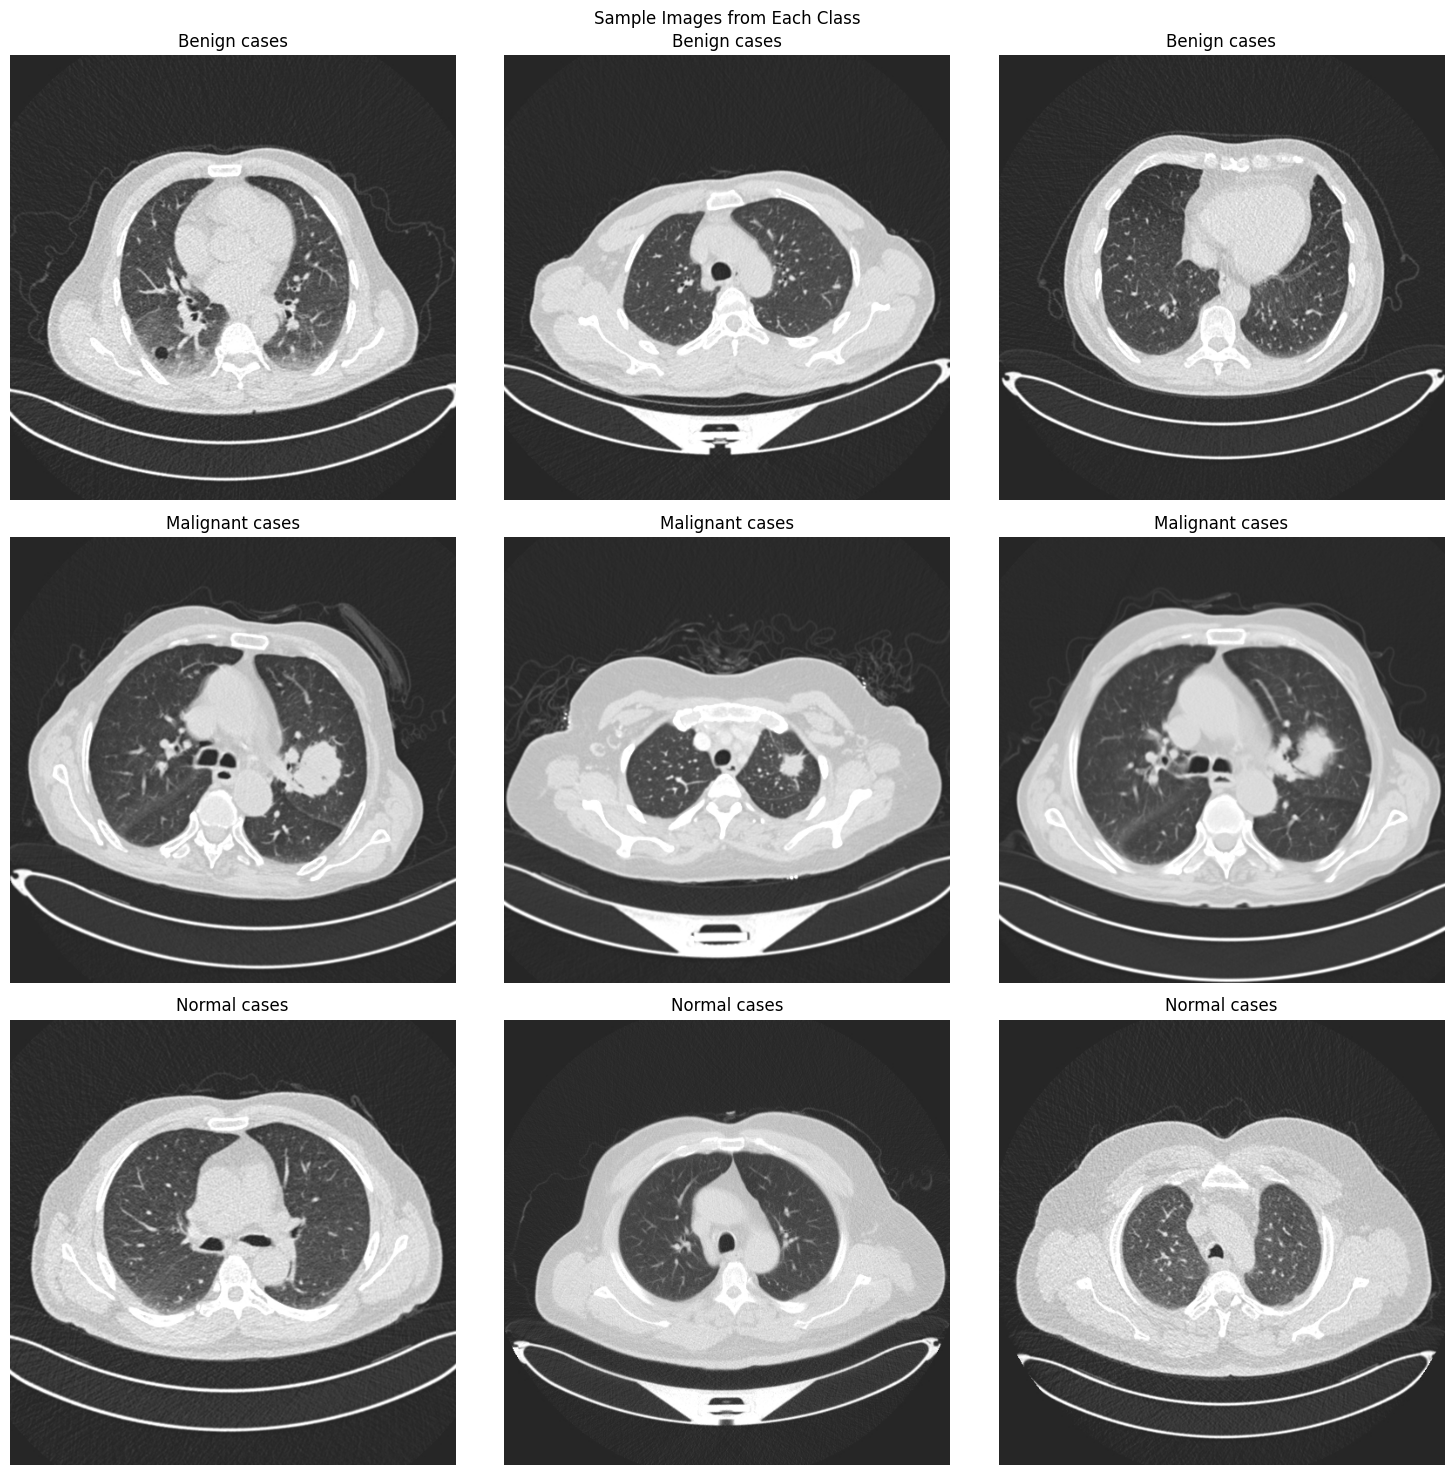

In [7]:
# Extract 3 samples from each class
benign_samples = df[df['Class'] == 'Benign cases'].sample(3)
malignant_samples = df[df['Class'] == 'Malignant cases'].sample(3)
normal_samples = df[df['Class'] == 'Normal cases'].sample(3)

# Combine the samples into one DataFrame
sampled_df = pd.concat([benign_samples, malignant_samples, normal_samples])

# Plotting the images
fig, axes = plt.subplots(3, 3, figsize=(15, 15))
fig.suptitle('Sample Images from Each Class')

for i, cls in enumerate(classes):
    class_samples = sampled_df[sampled_df['Class'] == cls]

    for j, (_, row) in enumerate(class_samples.iterrows()):

      # Open and plot each image using cv2
      img = cv2.imread(row['Image_Path'])
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      axes[i, j].imshow(img)
      axes[i, j].set_title(cls)
      axes[i, j].axis('off')

plt.tight_layout()
plt.subplots_adjust(top=0.95)
plt.show()

The images provided show X-Ray images of the thorax from three different classifications of lung conditions: `benign cases`, `malignant cases`, and `normal cases`. Here are some insights and characteristics for each class based on the visual information:

**Benign Cases**
   - **Appearance**:
     The scans show clear lungs with **no aggressive** or **large abnormal spots**. There are **small**, clearly outlined spots that are even in color and texture. There are no signs of severe lung damage or unusual growth patterns.
   - **Theoretical Background**:
     Benign spots in the lungs usually don't change much in size and grow slowly. They have smooth and clear edges, making them look distinct from more irregular and uneven spots that could be harmful.

**Malignant Cases**
   - **Appearance**:
     These scans show **unusual spots** or lumps with **rough, jagged edges**. These spots vary in color and texture and show signs of **damaging** the surrounding lung area, sometimes affecting the outer lung layer.
   - **Theoretical Background**:
     Harmful tumors grow quickly and irregularly because the cells grow out of control. They can spread into nearby areas, disrupting normal lung function and structure.

**Normal Cases**
   - **Appearance**:
     The scans **don’t show any unusual spots or lumps**. The breathing tubes and blood vessels are clearly visible without any twists or blockages, and the lung tissue looks uniformly healthy.
   - **Theoretical Background**:
     Healthy lungs show a good mix of air and tissue with clear sections and blood vessels, meaning the lungs are working well without any blockages or infections.

These points provide a clear understanding of the differences in lung health as seen on the X-ray images, helping to identify whether lungs look healthy, have benign (non-harmful) spots, or show signs of harmful tumors.

#### **ii. Class Distributions**

The next step in the exploratory analysis is to check the distribution of each class using a bar chart to visualize and compare the number of images in each category.

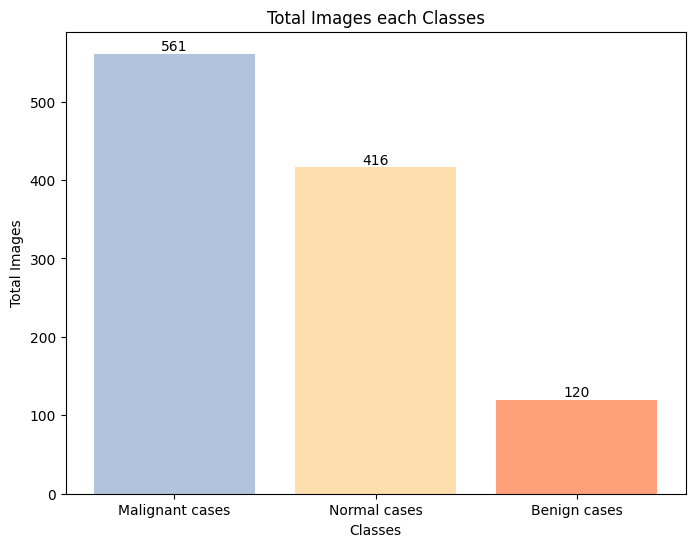

In [8]:
# Counts occurences of each class
class_counts = df['Class'].value_counts()

# Define list of colors
colors = ['lightsteelblue', 'navajowhite', 'lightsalmon']

# Plot the graph
plt.figure(figsize=(8, 6))
bars = plt.bar(class_counts.index, class_counts.values, color=colors[:len(class_counts)])
plt.xlabel('Classes')
plt.ylabel('Total Images')
plt.title('Total Images each Classes')

# Add the number of counts on top of each bar
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.05, int(yval), ha='center', va='bottom')

plt.show()

The bar chart shows the distribution of images for three classes of lung conditions.

1. **Malignant Cases**: Most numerous with 561 images, indicating a significant focus on capturing cancerous lung conditions, likely due to their complexity and severity.
2. **Normal Cases**: There are 416 images, indicating a similar focus on capturing what healthy lungs look like for comparison and analysis.
3. **Benign Cases**: Least represented with 120 images, possibly because these conditions are less critical than malignant cases.

The large number of malignant and normal images might improve diagnostics for these conditions while limiting understanding of benign ones.

#### **iii. Shape Distributions**

After examining the class distributions, the next step is to analyze the distributions of their shapes.

In [9]:
# Create empty list
heights = []
widths = []

# Iterate through all images and extract shape
for img_path in df['Image_Path']:
    # Load image
    img = cv2.imread(img_path)

    # Extract height and width
    height, width, _ = img.shape
    heights.append(height)
    widths.append(width)

# Add height and width columns to the DataFrame
df['Height'] = heights
df['Width'] = widths

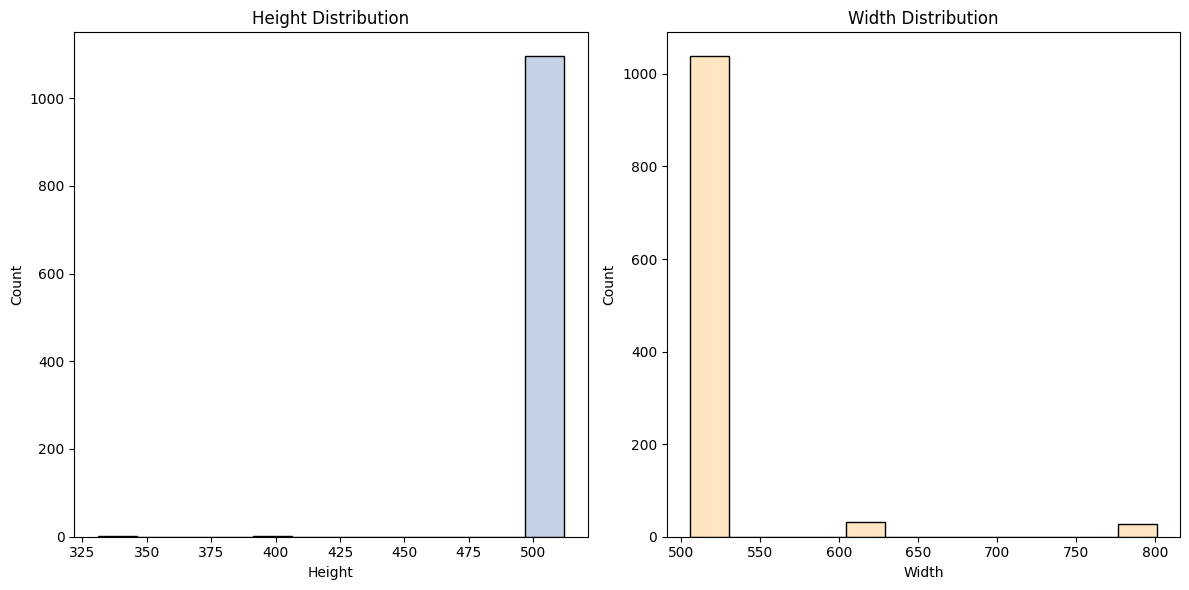

In [10]:
# Create subplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# Plot histogram for heights
sns.histplot(df['Height'], ax=axs[0], color='lightsteelblue')
axs[0].set_title('Height Distribution')

# Plot histogram for widths
sns.histplot(df['Width'], ax=axs[1], color='navajowhite')
axs[1].set_title('Width Distribution')

# Show plot
plt.tight_layout()
plt.show()

The bar charts display the height and width distribution of a dataset:

**Height Distribution**
- **Central Concentration**: The majority of the items are concentrated around a height of 500, indicating a standard height measurement across the dataset. However, there are also images with heights of 400 and 335.
- **Uniformity**: A sharp peak at 500 height suggests that nearly all items conform to this specific height, showing very little variation.

**Width Distribution**
- **Wider Range**: In contrast to height, the width measurements show a broader distribution from around 500 to 770.
- **Primary Peaks**: There is one main peak observed, at around 520 suggesting that items tend to cluster around this width measurements more frequently.

Overall, the dataset exhibits uniformity in height and width.

#### **iv. Color Distribution**

Next, exploring the color distribution will reveal how colors are used across the images in the dataset. This analysis will highlight the variety and prevalence of colors, giving a clearer picture of the visual composition of the dataset.

In [11]:
# Create empty list
color_distributions = []

# Iterate through all images
for img_path in df['Image_Path']:

    # Load image
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    # Extract color distribution
    mean_color_distributions = np.bincount(img.flatten(), minlength = 256)
    color_distributions.append(mean_color_distributions)

color_distributions = np.array(color_distributions)

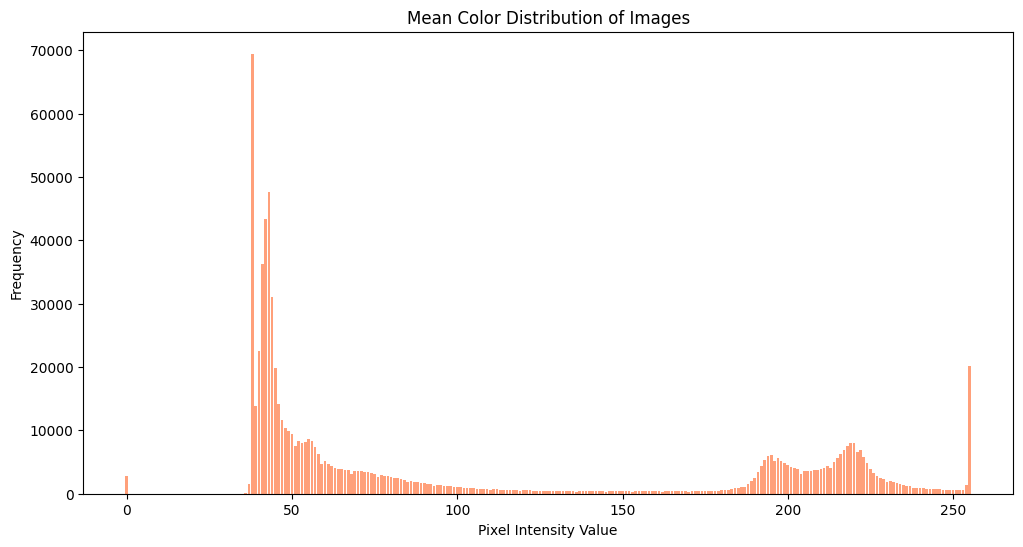

In [12]:
# Plotting the color distribution
mean_color_distribution = np.mean(color_distributions, axis=0)

plt.figure(figsize=(12, 6))
plt.bar(range(256), mean_color_distribution, color='lightsalmon')
plt.title('Mean Color Distribution of Images')
plt.xlabel('Pixel Intensity Value')
plt.ylabel('Frequency')
plt.show()

The histogram provides insights into the colors in an X-ray image of the lungs. There are two peaks on the graph, one around **75** and another around **250**, indicating **very dark** and **very bright** areas in the image. Moving from dark to medium colors, the graph declines, but there are still smaller bumps between 100 and 200, revealing mid-tone values. The peaks at the extremes suggest high-contrast areas or predominantly dark or light content.

When examining X-rays for conditions like malignant issues, normal lungs, or benign issues, the histogram helps understand the situation. For instance, if there's cancer, a big peak around 75 may appear due to dense and dark tumors. If it's benign, there might be smaller bumps in the middle range (100-200), showing some tissue density variations but nothing extreme. Normal lungs would have a smoother histogram curve without significant bumps, indicating an even spread of colors.

#### **v. Pixel Intensity Statistics**

Lastly, exploring the pixel intensity statistics—mean, median, and standard deviation—will provide insights into the overall brightness and contrast of the images.

In [13]:
# Create empty dictionary
class_intensity_stats = {}

# Iterate over unique classes in the DataFrame
for class_name in df['Class'].unique():

    class_df = df[df['Class'] == class_name]

    # Initialize lists to store pixel intensities of all images in the class
    intensity_values = []

    # Iterate over image paths in the filtered DataFrame
    for img_path in class_df['Image_Path']:

        # Load image
        img = cv2.imread(img_path)

        # Convert image to grayscale
        gray_img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        intensity_values.extend(gray_img.flatten())

    # Calculate statistics for intensity_values
    mean_intensity = np.mean(intensity_values)
    median_intensity = np.median(intensity_values)
    std_intensity = np.std(intensity_values)

    # Store statistics in the class_intensity_stats dictionary
    class_intensity_stats[class_name] = {'Mean Intensity': mean_intensity,
                                         'Median Intensity': median_intensity,
                                         'Standard Deviation of Intensity': std_intensity}

# Print statistics for each class
for class_name, stats in class_intensity_stats.items():
    print(f"Class: {class_name}")
    print(f"Mean Intensity: {stats['Mean Intensity']}")
    print(f"Median Intensity: {stats['Median Intensity']}")
    print(f"Standard Deviation of Intensity: {stats['Standard Deviation of Intensity']}")
    print()

Class: Benign cases
Mean Intensity: 101.17773685455322
Median Intensity: 52.0
Standard Deviation of Intensity: 77.29807015590447

Class: Malignant cases
Mean Intensity: 106.64783827271087
Median Intensity: 59.0
Standard Deviation of Intensity: 77.91518512123942

Class: Normal cases
Mean Intensity: 103.47403894551447
Median Intensity: 58.0
Standard Deviation of Intensity: 76.56158703661815



In the X-ray lung images:

- Benign cases have a mean intensity of **101.18**, a median intensity of **52.0**, and a standard deviation of **77.30**.
- Malignant cases have a mean intensity of **106.65**, a median intensity of **59.0**, and a standard deviation of **77.92**.
- Normal cases have a mean intensity of **103.47**, a median intensity of **58.0**, and a standard deviation of **76.56**.

These insights suggest that malignant cases tend to have slightly higher mean and median intensities compared to benign and normal cases. However, the standard deviation values show considerable variability within each class.

### **E. Feature Engineering**

After a thorough exploration and better understanding of the data, the next step involves preprocessing the images. This includes tasks such as **blurring, resizing, rescaling,** and **augmentation** to prepare them for model training.

#### **i. Data Splitting**

The first step is to divide the data into three sets: `training`, `validation`, and `testing`.

- **Training Set**: Represents 70% of the data and is used for **training** the model. It plays a role in adjusting model parameters to minimize loss and improve accuracy on the training data.

- **Validation Set**: Comprising 15% of the data, the validation set is used for **tuning hyperparameters** and evaluating model performance during training. It helps prevent overfitting by providing a separate dataset for validation without influencing the model's training process.

- **Testing Set**: Also accounting for 15% of the data, the testing set remains unseen during model training. It is used to **evaluate** the model's generalization and performance on new, unseen data, providing a measure of how well the model can predict outcomes in real-world scenarios.

In [14]:
# Define ratio
train_ratio = 0.70
test_ratio = 0.15
val_ratio = 0.15

# Split train, validation, and test
df_train, df_test_val = train_test_split(df, train_size = train_ratio, random_state = 42)
df_test, df_val = train_test_split(df_test_val, train_size = test_ratio/(test_ratio+val_ratio), random_state = 42)

# Print shapes
print(f"Train shape = {df_train.shape}")
print(f"Test shape = {df_test.shape}")
print(f"Validation shape = {df_val.shape}")

print("Data splitting complete.")

Train shape = (767, 4)
Test shape = (165, 4)
Validation shape = (165, 4)
Data splitting complete.


Data has been successfully split into training (767 samples), testing (165 samples), and validation (165 samples) sets.

In [15]:
# Group training set by the 'class' column
grouped_df_train = df_train.groupby('Class')

# Display the grouped data
for class_name, group in grouped_df_train:
    print(f"Class: {class_name}")
    print(group.head())
    print("\n")

# Count each class
class_counts = df_train['Class'].value_counts()
print("Class counts in training data:")
print(class_counts)

Class: Benign cases
                                           Image_Path         Class  Height  \
71  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
94  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
33  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
77  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
84  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   

    Width  
71    512  
94    512  
33    512  
77    512  
84    512  


Class: Malignant cases
                                            Image_Path            Class  \
305  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
354  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
249  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
482  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
259  /content/drive/MyDrive/Hackt

The training data has 80 samples of benign cases, 387 samples of malignant cases, and 300 samples of normal cases. Malignant cases are the most represented class in the training data.

In [16]:
# Group validation set by the 'class' column
grouped_df_val = df_val.groupby('Class')

# Display the grouped data
for class_name, group in grouped_df_val:
    print(f"Class: {class_name}")
    print(group.head())
    print("\n")

# Count each class
class_counts = df_val['Class'].value_counts()
print("Class counts in validation data:")
print(class_counts)

Class: Benign cases
                                            Image_Path         Class  Height  \
59   /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
96   /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
109  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
83   /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
51   /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   

     Width  
59     512  
96     512  
109    512  
83     512  
51     512  


Class: Malignant cases
                                            Image_Path            Class  \
666  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
198  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
334  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
597  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
615  /content/drive/M

The validation dataset consists of 18 benign, 87 malignant, and 60 normal cases. Malignant cases are the most numerous, followed by normal and then benign cases.

In [17]:
# Group testing set by the 'class' column
grouped_df_test = df_test.groupby('Class')

# Display the grouped data
for class_name, group in grouped_df_test:
    print(f"Class: {class_name}")
    print(group.head())
    print("\n")

# Count each class
class_counts = df_test['Class'].value_counts()
print("Class counts in testing data:")
print(class_counts)

Class: Benign cases
                                            Image_Path         Class  Height  \
56   /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
100  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
110  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
76   /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   
60   /content/drive/MyDrive/Hacktive8/P2G7/Training...  Benign cases     512   

     Width  
56     512  
100    512  
110    512  
76     512  
60     512  


Class: Malignant cases
                                            Image_Path            Class  \
626  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
346  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
333  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
656  /content/drive/MyDrive/Hacktive8/P2G7/Training...  Malignant cases   
541  /content/drive/M

The testing data comprises 22 benign, 87 malignant, and 56 normal cases. Malignant cases are the most numerous in this dataset, followed by normal and then benign cases.

#### **ii. Data Pre-Processing**

After dividing the data into three sets, the next step is to standardize the image preprocessing procedures to ensure uniformity across the dataset. This includes tasks such as **rescaling, resizing, noise reduction (blurring)** and applying **augmentation** techniques to enhance the diversity of the data for better model generalization. Standardizing these preprocessing steps helps maintain consistency in the input data format, ensuring that the model can effectively learn and generalize patterns from the images during training.

In [18]:
# Define image size and batch size
width = 256
height = 256
image_size = (width, height)
batch_size = 32

# Create function to apply median blur
def preprocessing_denoise(img):
    denoise_img = cv2.medianBlur(img, 1)
    denoise_img = cv2.cvtColor(denoise_img, cv2.COLOR_BGR2RGB)
    return denoise_img

# Define generator for training and validation
train_datagen = ImageDataGenerator(rescale = 1./255.,
                                   preprocessing_function = preprocessing_denoise,
                                   rotation_range = 30,
                                   width_shift_range = 0.1,
                                   height_shift_range = 0.2,
                                   shear_range = 0.1,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

# Define generator for testing
test_datagen = ImageDataGenerator(rescale = 1./255.)

# Splitting training, validation, and testing set
train_generator = train_datagen.flow_from_dataframe(df_train,
                                                    x_col = "Image_Path",
                                                    y_col = "Class",
                                                    target_size = image_size,
                                                    batch_size = batch_size,
                                                    color_mode = "rgb",
                                                    class_mode = "categorical",
                                                    shuffle = False)

val_generator = test_datagen.flow_from_dataframe(df_val,
                                                 x_col = "Image_Path",
                                                 y_col = "Class",
                                                 target_size = image_size,
                                                 batch_size = batch_size,
                                                 color_mode = "rgb",
                                                 class_mode = "categorical",
                                                 shuffle = False)

test_generator = test_datagen.flow_from_dataframe(df_test,
                                                  x_col = "Image_Path",
                                                  y_col = "Class",
                                                  target_size = image_size,
                                                  batch_size = batch_size,
                                                  color_mode = "rgb",
                                                  class_mode = "categorical",
                                                  shuffle = False)

Found 767 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.
Found 165 validated image filenames belonging to 3 classes.


The image size is set to **256x256** pixels, and the batch size is **32**. A preprocessing function called `preprocessing_denoise` is created using OpenCV's **median blur** method to reduce noise and convert images to RGB format.

Data generators for training, validation, and testing are then set up using `ImageDataGenerator`. For training, images are **rescaled, resized** and **preprocessed** with `preprocessing_denoise`, and augmentation techniques like rotation, shifting, shear, zoom, and flipping are applied. The testing generator only rescales images without augmentation.

These generators read image paths and class labels from DataFrames (`df_train`, `df_val`, and `df_test`), with RGB color mode and **categorical** class mode, suitable for handling **multiple classes**. Shuffling is enabled to `False` to make sure the images remains the same.

To verify the data splitting, images will be displayed according to their respective sets.

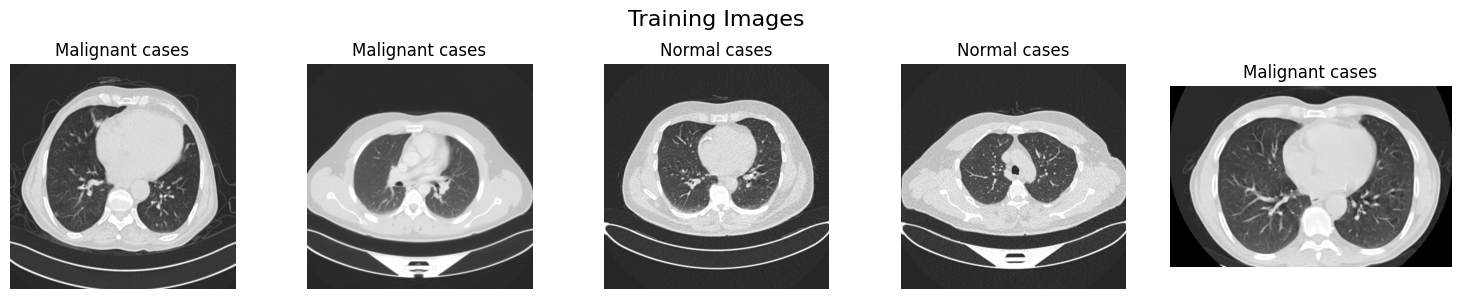

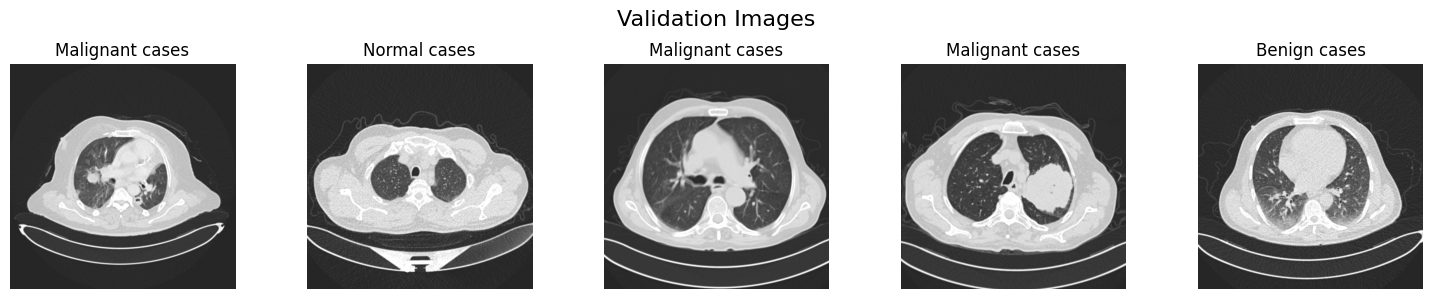

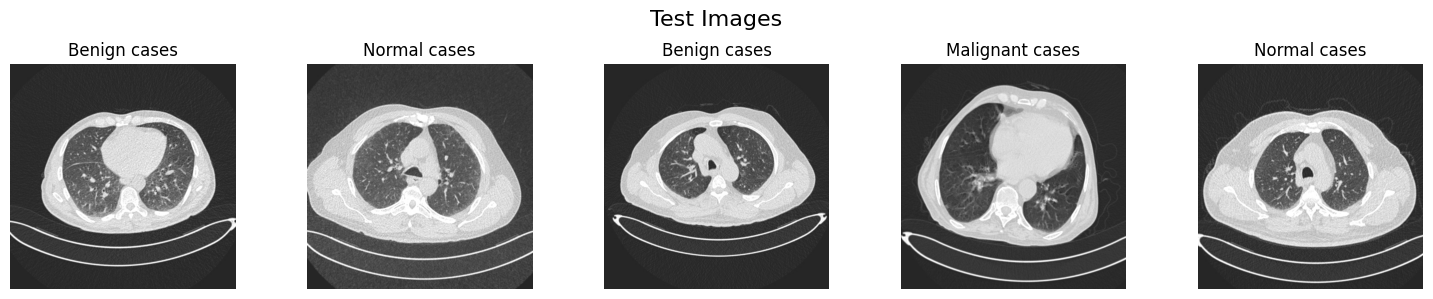

In [19]:
# Define class_names from unique values in the 'Class' column
class_names = df_train['Class'].unique().tolist()

# Function to plot images in a grid
def plot_images(images_arr, labels_arr, class_names, title):
    fig, axes = plt.subplots(1, 5, figsize=(15, 3))
    fig.suptitle(title, fontsize=16)
    axes = axes.flatten()
    for img_path, lbl, ax in zip(images_arr, labels_arr, axes):
        img = Image.open(img_path)
        ax.imshow(img)
        ax.set_title(class_names[lbl])
        ax.axis('off')
    plt.tight_layout()
    plt.subplots_adjust(top=0.8)
    plt.show()

# Sample images and labels from the training set
images_train = df_train['Image_Path'].values[:5]
labels_train = df_train['Class'].apply(lambda x: class_names.index(x)).values[:5]
plot_images(images_train, labels_train, class_names, title='Training Images')

# Sample images and labels from the validation set
images_val = df_val['Image_Path'].values[:5]
labels_val = df_val['Class'].apply(lambda x: class_names.index(x)).values[:5]
plot_images(images_val, labels_val, class_names, title='Validation Images')

# Sample images and labels from the test set
images_test = df_test['Image_Path'].values[:5]
labels_test = df_test['Class'].apply(lambda x: class_names.index(x)).values[:5]
plot_images(images_test, labels_test, class_names, title='Test Images')

The images have been successfully divided into their respective sets. The displayed images above represent 5 samples from each set.

### **F. ANN Training**

After preprocessing the images, the next step involves training the data using two different models: **sequential** and **functional**.

- **Sequential Model**: A straightforward architecture where layers are stacked linearly, suitable for simpler models. However, it may not handle complex architectures with multiple inputs/outputs or skip connections.

- **Functional Model**: Offers more flexibility by defining layers as separate objects and connecting them using the functional API. This allows for complex architectures with multiple inputs/outputs, making it suitable for tasks involving skip connections.

Both models will be trained using the preprocessed image data to learn the patterns and features necessary for accurate classification of the lung images into their respective classes. The key evaluation metric used is **accuracy** because it provides a clear measure of how often the predictions match the actual labels. Accuracy is crucial for evaluating the effectiveness of a multi-class classifier, as it directly reflects the model's ability to correctly identify each class. Even though the dataset is imbalanced, it will be handled using **class weights** to prevent bias.

[Reference](https://www.analyticsvidhya.com/blog/2021/07/understanding-sequential-vs-functional-api-in-keras/)

#### **Model Sequential**

Begin by defining the sequential model, then proceed with training and evaluation.

##### **i. Model Definition**

This section focuses on defining the model architecture.

In [20]:
# Set random seed and clear any existing Keras session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [21]:
# Create the model
model1 = Sequential()

# First Conv Block
model1.add(Conv2D(32, (3, 3), activation='relu', input_shape=(height, width, 3)))
model1.add(BatchNormalization())
model1.add(MaxPooling2D((2, 2)))

# Second Conv Block
model1.add(Conv2D(64, (3, 3)))
model1.add(BatchNormalization())
model1.add(ReLU())
model1.add(MaxPooling2D((2, 2)))

# Third Conv Block
model1.add(Conv2D(64, (3, 3)))
model1.add(BatchNormalization())
model1.add(ReLU())
model1.add(MaxPooling2D((2, 2)))

# Fully connected layer
model1.add(GlobalAveragePooling2D())
model1.add(Dense(128, activation='relu'))
model1.add(Dropout(0.2))
model1.add(Dense(256, activation='relu'))
model1.add(Dropout(0.2))

# Output layer
model1.add(Dense(3, activation='softmax'))

The model features three convolutional blocks, each followed by batch normalization, ReLU activation, and max pooling. The fully connected layers include two dense layers with ReLU activation and dropout for regularization. The output layer uses softmax activation for multi-class classification with three output units.

Here's what each layer does:

- **Conv2D (Convolutional Layer)**: Performs convolutional operations to extract features by filtering input images with a specified kernel size, aiding in pattern capture.
- **BatchNormalization**: Normalizes input data, stabilizing training by reducing internal covariate shift and enhancing network performance.
- **ReLU Activation**: Introduces non-linearity to learn complex patterns and relationships in data through weighted connections.
- **MaxPooling2D (Max Pooling Layer)**: Used to downsample the spatial dimensions of the input data while retaining important information.
- **GlobalAveragePooling2D**: Aggregates spatial information by computing average values, aiding in feature extraction and reducing overfitting.
- **Dense (Fully Connected Layer)**: Connects every neuron, learning high-level abstractions and performing classification tasks.
- **Dropout**: Prevents overfitting by randomly setting input units to zero during training, enhancing model generalization.
- **Softmax Activation**: Converts logits to probabilities for multi-class classification, ensuring sum of predicted probabilities equals one.

[Reference 1](https://data-flair.training/blogs/keras-layers/)  
[Reference 2](https://keras.io/api/layers/pooling_layers/global_average_pooling2d/)

In the model, the kernel size is smaller than the pooling size, a strategy that helps in reducing spatial dimensions early in the network while still capturing relevant features.

Notably, the model **does not use strides or padding**. Strides determine the step size of the convolution kernel or pooling window across input data, potentially causing **information loss** by skipping parts of the data. This lost information can be valuable for classifying lung cases.

Padding is also not used in this model as it adds unnecessary zeros around the input, which is **irrelevant** since the images have black edges and contain essential information mostly in the **center**. These edge areas lack meaningful information that contributes significantly to the model's learning process.

[Reference 1](https://community.deeplearning.ai/t/about-kernel-size-pool-size-and-strides-in-advace-computer-vision-week-3/412137)  
[Reference 2](https://medium.com/analytics-vidhya/convolution-padding-stride-and-pooling-in-cnn-13dc1f3ada26)

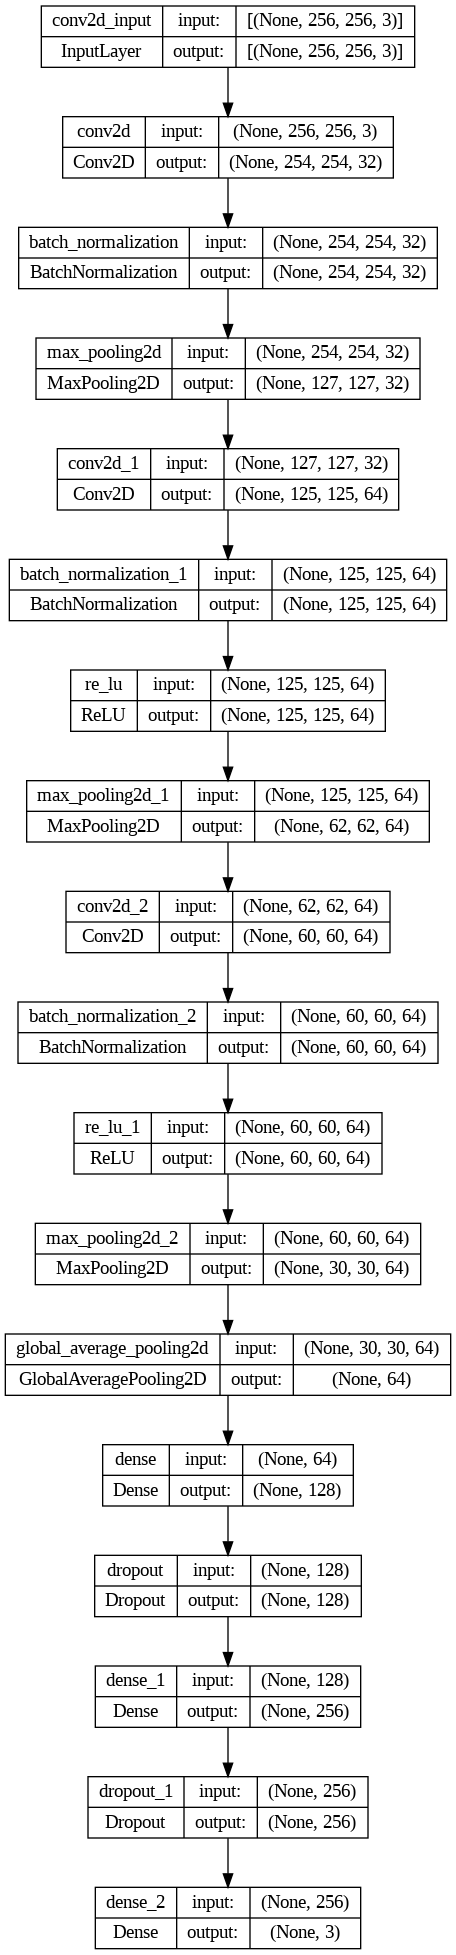

In [22]:
# Plot layers
tf.keras.utils.plot_model(model1, show_shapes=True)

The image above displays a model architecture diagram, which outlines the structure of the sequential model. It details the input and output shapes of each layer, providing a clear visual representation of how data is processed and transformed throughout the network.

Following the layer plot, the model is compiled.

In [23]:
# Compile the model
model1.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

The model is compiled using the **Adam optimizer** with a learning rate of **0.001**. The loss function used is **categorical cross-entropy**, suitable for **multi-class** classification tasks. Accuracy is set as the evaluation metric to track the model's performance.

##### **ii. Model Training**

After defining the model, it is trained using the training set and validated using the validation set to consistently minimize error with each epoch.

However, before training the model, the imbalance data needs to be handled. This section applies class weights to imprpve the imbalanced data in the training set. The `class_weight.compute_class_weight` function calculates balanced class weights based on the frequency of each class in the training data.

[Reference](https://www.analyticsvidhya.com/blog/2020/10/improve-class-imbalance-class-weights/)

In [24]:
# Define classes
classes = list(train_generator.class_indices.keys())

# Apply class weight to handle imbalance data
class_weights = class_weight.compute_class_weight(class_weight = 'balanced',
                                                  classes = np.unique(train_generator.classes),
                                                  y = train_generator.classes)

train_class_weights = dict(enumerate(class_weights))

for idx, weight, in train_class_weights.items():
    class_name = classes[idx]
    print(f"{class_name} : {weight}")

Benign cases : 3.1958333333333333
Malignant cases : 0.6606373815676141
Normal cases : 0.8522222222222222


The class weights indicate that **benign cases** are **minority**, so their weight is **higher** compared to the other two. The weights for malignant and normal cases are lower, reflecting their greater representation in the dataset. This helps balance the model's focus across all classes.

After handling class imbalance with class weights, the next step is to define the learning rate scheduler and early stopping.

In [25]:
# Create function to schedule learning rate
def lr_schedule(epoch, lr):
    initial_lr = 0.001
    if epoch < 10:
        return initial_lr
    else:
        return initial_lr * math.exp(-0.1 * (epoch - 10))

# Define the learning rate scheduler callback
lr_scheduler = LearningRateScheduler(lr_schedule, verbose=1)

# Define callbacks to perform early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

The learning rate schedule is created with a function that adjusts the learning rate based on the epoch. Initially, the learning rate is set to **0.001** for the first **10** epochs. After that, it decreases exponentially to ensure the model converges smoothly over time.

Early stopping is also used during model training to prevent overfitting by terminating training when the model's performance on a validation set starts deteriorating. In this case, the monitoring metric is the **validation loss**, and a patience of 10 epochs means that training will stop if there is no improvement in validation loss for **10** consecutive epochs.

The model is ready for training using 50 epochs, using both the training and validation datasets.

In [26]:
%%time

# Model training
history = model1.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[lr_scheduler, early_stopping])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
24/24 [==============================] - 28s 837ms/step - loss: 0.8173 - accuracy: 0.6428 - val_loss: 0.9822 - val_accuracy: 0.5273 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
24/24 [==============================] - 18s 751ms/step - loss: 0.5663 - accuracy: 0.7849 - val_loss: 2.7908 - val_accuracy: 0.5273 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
24/24 [==============================] - 18s 755ms/step - loss: 0.4525 - accuracy: 0.8253 - val_loss: 5.5708 - val_accuracy: 0.5273 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/50
24/24 [==============================] - 20s 842ms/step - loss: 0.4412 - accuracy: 0.8396 - val_loss: 7.9163 - val_accuracy: 0.5273 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/50
24/24 [==============================] - 26s 

The training process ran for **11** epochs, and it took approximately **3 minutes and 52 seconds** to complete. The last saved scores for the model were a training loss of **0.3928**, training accuracy of **0.8592**, validation loss of **12.6552**, and validation accuracy of **0.5273**.

Based on the accuracy scores, it is evident that the model is **overfitting**, performing well on the training data but failing to generalize to unseen data.

##### **iii. Model Evaluation**

The trained model is then evaluated using three methods: assessing the **training and validation loss and accuracy**, generating **classification reports** and **confusion matrix** for the test set.

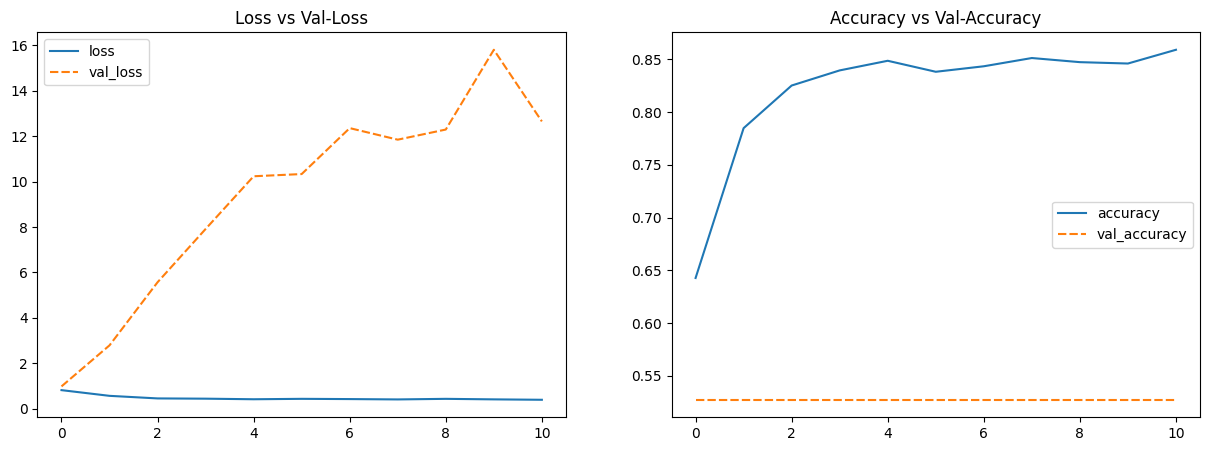

In [27]:
# Plot training results

history_df = pd.DataFrame(history.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df[['loss', 'val_loss']])
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df[['accuracy', 'val_accuracy']])
plt.title('Accuracy vs Val-Accuracy')
plt.show()

The charts show the performance of the sequential model through training and validation phases. The X axis represents epoch, while y axis represents the scores.

- **Loss Chart**: The blue line represents the model's training loss, which steadily decreases, indicating that the model is effectively learning from the training data. The orange dashed line, representing validation loss, continues to rise, suggesting that the model may be overfitting, meaning it's learning the training data too well and failing to generalize to new data.

- **Accuracy Chart**: The blue line for training accuracy shows a quick increase and then levels off, which means the model is learning well. The orange dashed line for validation accuracy remains relatively unchanged and much lower than the training accuracy, further indicating overfitting.

These trends validated the previous findings that while the model performs well on the training set, it struggles to perform similarly on new, unseen data.

In [28]:
# Check the performance of test-set

# Get the probability predictions
y_pred_prob1 = model1.predict(test_generator)

# Get class with maximum probability
y_pred_class1 = np.argmax(y_pred_prob1, axis=-1)

# Get the true labels from the test data generator
y_true = test_generator.classes

# Get the class names from the testing data generator
class_names = list(test_generator.class_indices.keys())

# Display Classification Report
print(classification_report(y_true, y_pred_class1, target_names=class_names))

6/6 [==============================] - 1s 184ms/step
                 precision    recall  f1-score   support

   Benign cases       0.00      0.00      0.00        22
Malignant cases       0.53      1.00      0.69        87
   Normal cases       0.00      0.00      0.00        56

       accuracy                           0.53       165
      macro avg       0.18      0.33      0.23       165
   weighted avg       0.28      0.53      0.37       165



The classification model achieves an overall accuracy of **53%** across 165 cases. This indicates that the model correctly predicts the outcome for approximately half of the cases it is tested against. However, the accuracy is primarily driven by its performance on `Malignant cases`, where it has a recall of 100% but significantly **underperforms** in accurately identifying `Benign cases` and `Normal cases`, with both categories having 0% precision and recall. This suggests the model is **biased** towards predicting `Malignant cases` more frequently, leading to its overall moderate accuracy.

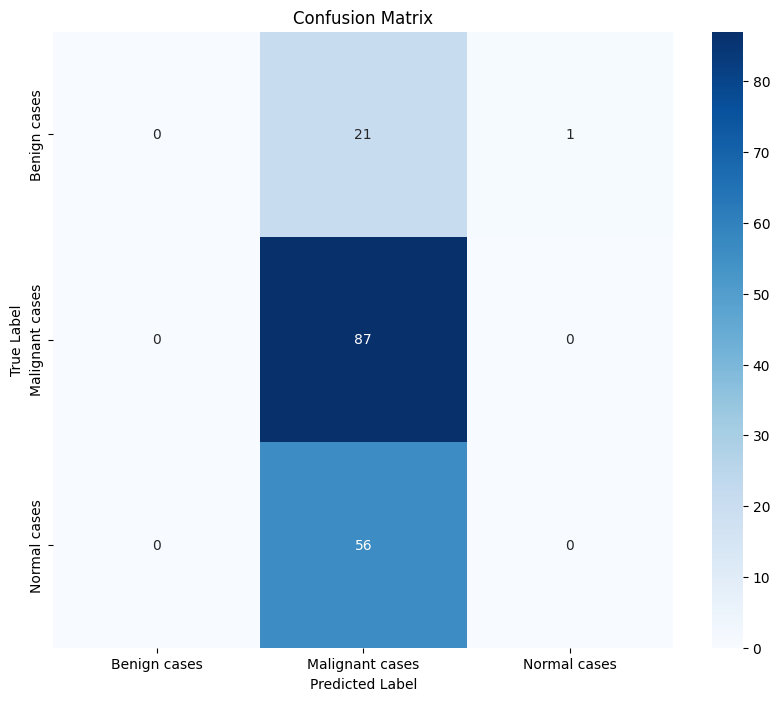

In [29]:
# Generate the confusion matrix
cm1 = confusion_matrix(y_true, y_pred_class1)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm1, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix shows that the model accurately **identified all malignant cases** (87 out of 87), but it failed to correctly identify any benign or normal cases, classifying all as malignant. This indicates a **significant bias** in the model towards predicting cases as malignant, which although contributes to its high accuracy for malignant cases, reflects poor performance and lack of reliability in generalizing across different case types.

#### **Model Functional**

The sequential model's performance is still unsatisfactory. Next, the model will be implemented using the functional approach.

##### **i. Model Definition**

This section focuses on defining the model architecture.

In [30]:
# Set random seed and clear any existing Keras session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [31]:
# Define input layer
input_layer = Input(shape=(height, width, 3))

# First Conv Block
layer1 = Conv2D(32, (3, 3), activation='relu')(input_layer)
layer1 = BatchNormalization()(layer1)
layer1 = MaxPooling2D((2, 2))(layer1)

# Second Conv Block
layer2 = Conv2D(64, (3, 3), activation='relu')(layer1)
layer2 = BatchNormalization()(layer2)
layer2 = ReLU()(layer2)
layer2 = MaxPooling2D((2, 2))(layer2)

# Resize layer2 to match the shape of layer1
layer2_resized = tf.image.resize(layer2, (layer1.shape[1], layer1.shape[2]))

# Concatenate the resized layer2 with layer1
layer = Concatenate()([layer1, layer2_resized])

# Third Conv Block
layer = Conv2D(128, (3, 3), activation='relu')(layer)
layer = BatchNormalization()(layer)
layer = ReLU()(layer)
layer = MaxPooling2D((2, 2))(layer)

# Fully connected layer
layer = GlobalAveragePooling2D()(layer)
layer = Dense(256, activation='relu')(layer)
layer = Dropout(0.2)(layer)
layer = Dense(256, activation='relu')(layer)
layer = Dropout(0.2)(layer)

# Output layer
output_layer = Dense(3, activation='softmax')(layer)

# Create model
model2 = Model(inputs=input_layer, outputs=output_layer)

The functional model features three convolutional blocks, each followed by batch normalization, ReLU activation, and max pooling. The fully connected layers include two dense layers with ReLU activation and dropout for regularization. The output layer uses softmax activation for multi-class classification with three output units.

Here's what each layer does:

- **Concatenate**: Combines the resized output of the second block with the first block's output to merge features from different layers.

The other layers—Conv2D, BatchNormalization, ReLU Activation, MaxPooling2D, GlobalAveragePooling2D, Dense, Dropout, and Softmax Activation—are already defined above.

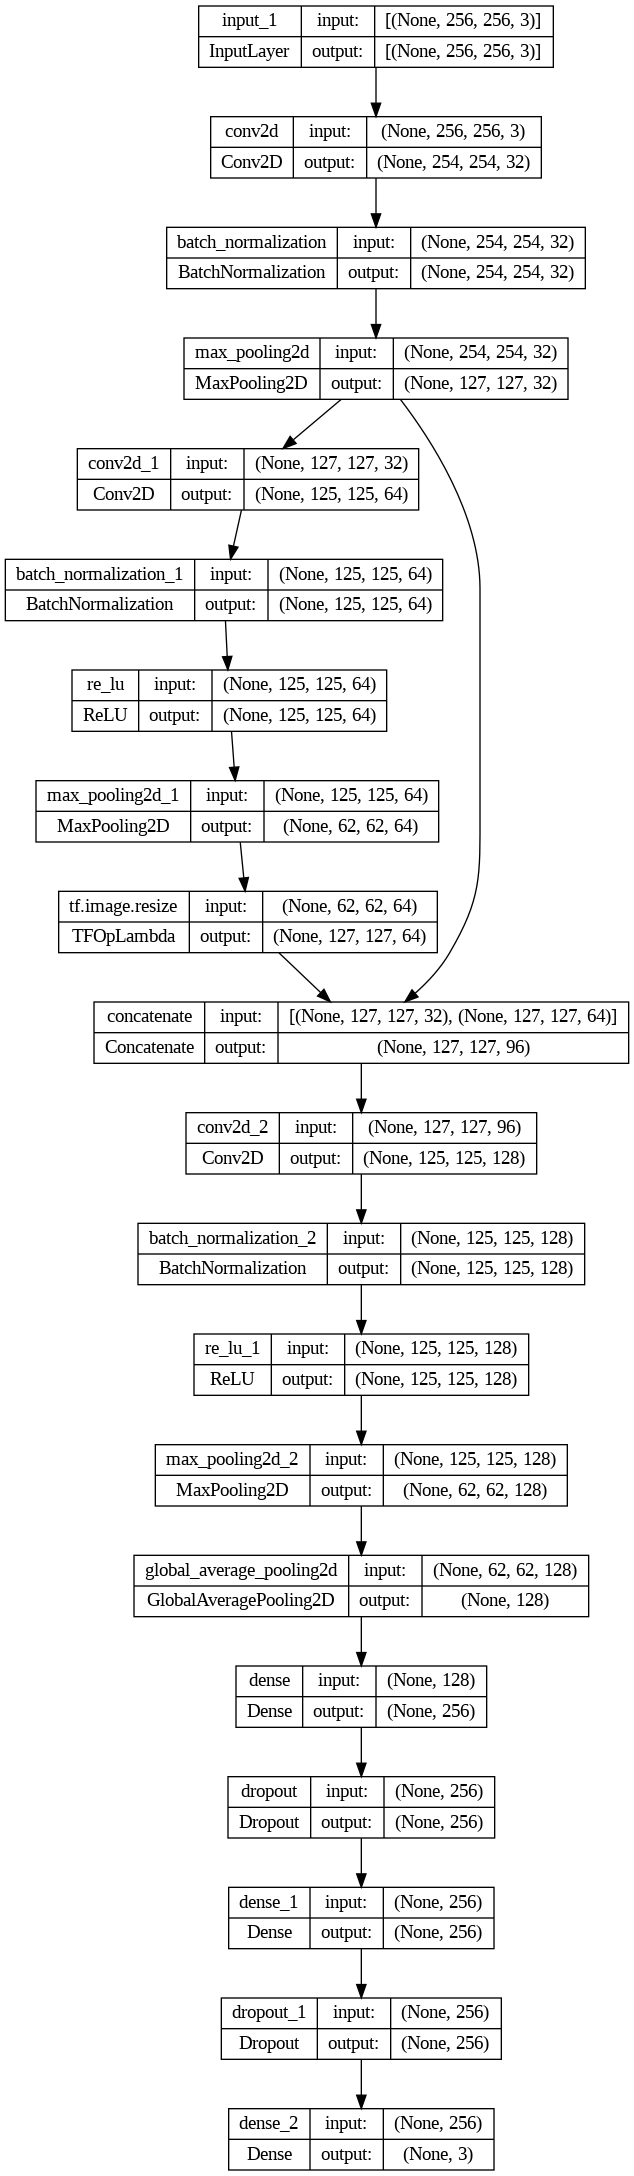

In [32]:
# Plot layers
tf.keras.utils.plot_model(model2, show_shapes=True)

The image above displays a model architecture diagram, outlining the structure of the functional model. It highlights the concatenation of the first and second hidden layers.

Following the layer plot, the model is compiled.

In [33]:
# Compile the model
model2.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

The model compilation remains the same as in the sequential model.

##### **ii. Model Training**

After defining the model, it is retrained using the training set and validated with the validation set to consistently reduce errors with each epoch.

The model is ready for training using 50 epochs, using both the training and validation datasets.

In [34]:
%%time

# Model training
history2 = model2.fit(train_generator, epochs=50, validation_data=val_generator, callbacks=[early_stopping, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/50
24/24 [==============================] - 27s 829ms/step - loss: 0.7486 - accuracy: 0.6884 - val_loss: 0.9691 - val_accuracy: 0.6000 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/50
24/24 [==============================] - 20s 813ms/step - loss: 0.4863 - accuracy: 0.8240 - val_loss: 0.9284 - val_accuracy: 0.6000 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/50
24/24 [==============================] - 19s 773ms/step - loss: 0.4286 - accuracy: 0.8540 - val_loss: 0.9173 - val_accuracy: 0.5879 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/50
24/24 [==============================] - 20s 855ms/step - loss: 0.4154 - accuracy: 0.8462 - val_loss: 1.0105 - val_accuracy: 0.5576 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/50
24/24 [==============================] - 21s 

The training process ran for **13** epochs, and it took approximately **5 minutes 26 seconds** to complete. The last saved scores for the model were a training loss of **0.3507**, training accuracy of **0.8579**, validation loss of **2.2612**, and validation accuracy of **0.5636**.

In comparison to the previous model, this one might offer **faster training times** and **improved accuracy scores**. Nevertheless, it still demonstrates signs of **overfitting**, struggling to generalize beyond the training data.

##### **iii. Model Evaluation**

Same as before, the trained model is then evaluated using three methods: assessing the **training and validation loss and accuracy**, generating **classification reports** and **confusion matrix** for the test set.

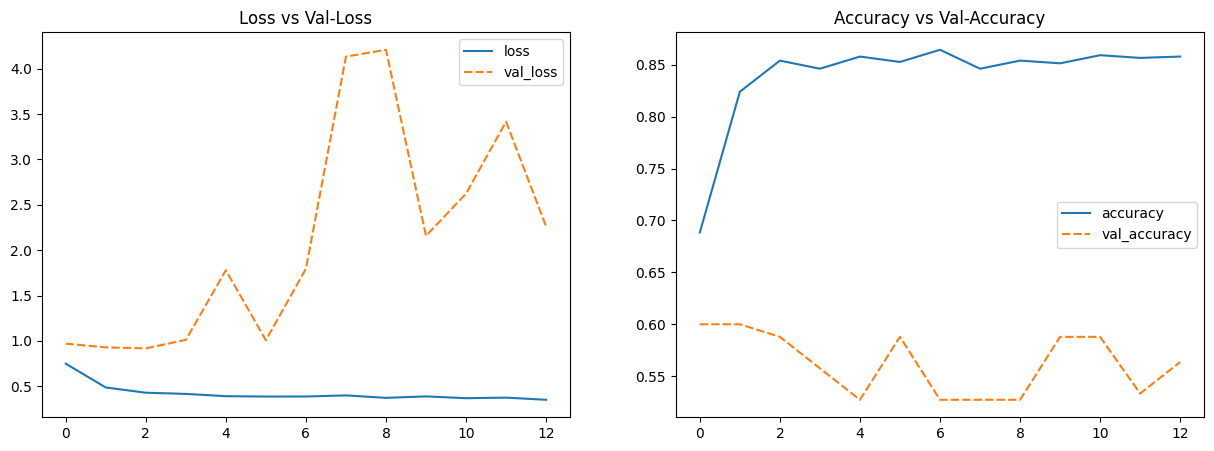

In [35]:
# Plot training results

history_df2 = pd.DataFrame(history2.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df2[['loss', 'val_loss']])
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df2[['accuracy', 'val_accuracy']])
plt.title('Accuracy vs Val-Accuracy')
plt.show()

The charts represent the training and validation performance of a machine learning model over 12 epochs:

- **Loss Chart**: The training loss (blue line) decreases consistently, indicating the model is learning effectively from the training data. In contrast, the validation loss (orange dashed line) shows significant volatility, spiking at certain epochs, which may suggest issues like overfitting or model sensitivity to validation data specifics.

- **Accuracy Chart**: The training accuracy (blue line) is high and remains stable after a sharp initial increase, suggesting the model performs well on training data. However, the validation accuracy (orange dashed line) starts low and peaks dramatically towards the later epochs before dropping again, reflecting potential instability in how the model generalizes to unseen data.

These patterns indicate the model might be **overfitting** the training data and not performing consistently on validation data.

In [36]:
# Check the performance of test-set

# Get the probability
y_pred_prob2 = model2.predict_generator(test_generator)

# Get class with maximum probability
y_pred_class2 = np.argmax(y_pred_prob2, axis=-1)

# Get the true labels from the test data generator
y_true2 = test_generator.classes

# Get the class names from the training data generator
class_names = list(train_generator.class_indices.keys())

## Display Classification Report
print(classification_report(y_true2, y_pred_class2, target_names=class_names))

                 precision    recall  f1-score   support

   Benign cases       0.00      0.00      0.00        22
Malignant cases       0.56      1.00      0.72        87
   Normal cases       0.91      0.18      0.30        56

       accuracy                           0.59       165
      macro avg       0.49      0.39      0.34       165
   weighted avg       0.61      0.59      0.48       165



The classification model evaluated 165 cases, achieving an overall accuracy of **59%**. This is primarily due to its effectiveness in identifying `Malignant case`, where it has a high recall of 100% but only moderate precision of 56%. In contrast, it completely **fails** to identify `Benign case` and performs **poorly** on `Normal case`. This skewed performance indicates that while the model is good at detecting `Malignant case`, it struggles significantly with `Benign case` and `Normal case`, highlighting the need for improvements to achieve balanced accuracy across all categories.

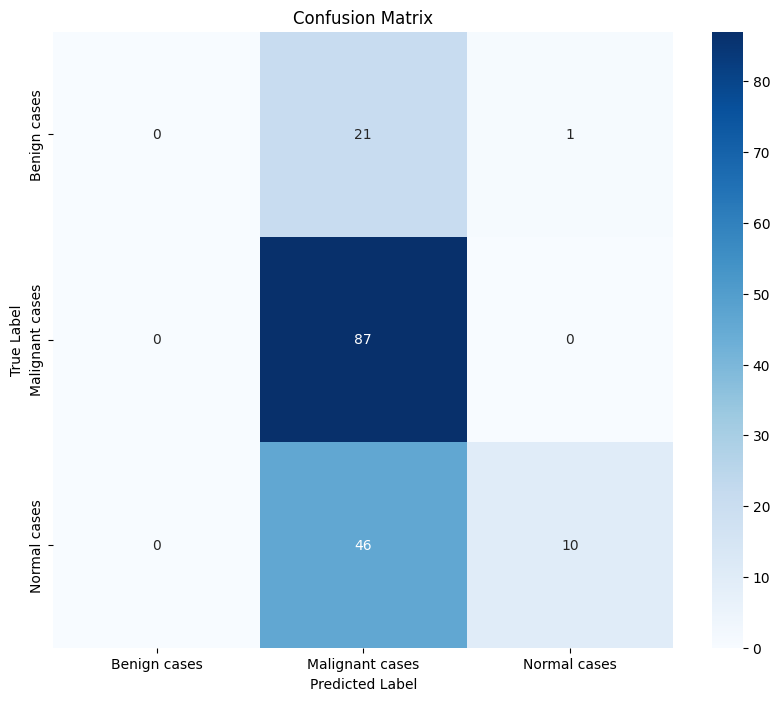

In [37]:
# Generate the confusion matrix
cm2 = confusion_matrix(y_true, y_pred_class2)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm2, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

The confusion matrix reveals that the classification model is highly effective at identifying malignant cases, with **87 true positives** and **0** false negatives, showcasing excellent sensitivity in medical diagnostics for these conditions. However, it struggles significantly with normal and benign cases, misclassifying **46** normal cases as malignant and incorrectly labeling all **21** benign cases as malignant, with **1** case misclassified as normal. This suggests a strong bias towards predicting more severe conditions and indicates a need for model improvement to enhance its accuracy in distinguishing between benign and normal conditions, potentially through more balanced data or refined model parameters.

### **G. ANN Improvement with Transfer Learning**

After experimenting with both sequential and functional models, it has been observed that while the model achieves high accuracy on the training set, it struggles with unseen data. However, this performance gap can be significantly improved through the application of **Transfer Learning**. Transfer Learning is a technique in machine learning where knowledge gained from training on one task is used to improve performance on a different but related task.

For this analysis, the model of choice will be **Xception**. Xception is known for its effectiveness in image classification tasks due to its deep architecture and the utilization of depthwise separable convolutions. It has demonstrated remarkable accuracy and efficiency, especially when dealing with complex visual recognition challenges.

The Xception network used in this context is pretrained on the ImageNet dataset. ImageNet is a vast dataset containing millions of labeled images across thousands of categories, making it a valuable resource for training deep learning models. Pretraining on ImageNet allows the Xception model to learn rich and generalized features from diverse visual data, which can then be fine-tuned to improve performance on specific tasks or datasets.

[Reference](https://medium.com/@nutanbhogendrasharma/image-classification-with-xception-model-e8094a9de4d2)

#### **i. Pre-processing**

However, the Xception model has a different input shape which is **299x299**, therefore it needs redefinition in this section. In this section, the input shape is specify and the Xception model is loaded.

In [38]:
# Define hyperparameters
height= 299
width= 299

In [39]:
# Download pretrained model
pretrained_model = Xception(weights='imagenet', include_top=False, input_shape=(height, width, 3))
pretrained_model.trainable = False

The model has been successfully downloaded and configured with its corresponding input shape.

#### **ii. Model Definition**

After loading the pre-trained model, this section focuses on defining the model architecture.

In [40]:
# Set random seed and clear any existing Keras session
seed = 20
tf.keras.backend.clear_session()
np.random.seed(seed)
tf.random.set_seed(seed)

In [41]:
# Create transfer learning model

model3 = Sequential()

model3.add(pretrained_model)
model3.add(GlobalAveragePooling2D())
model3.add(Dropout(0.2))
model3.add(Dense(256, activation='relu'))

model3.add(Dense(3, activation='softmax'))

This transfer learning model uses the Xception pretrained model as its foundation. It includes a Global Average Pooling 2D layer to connect features, a Dropout layer for regularization, a Dense layer uses ReLU activation to capture high-level features, and an output Dense layer with softmax activation designed for multi-class classification.

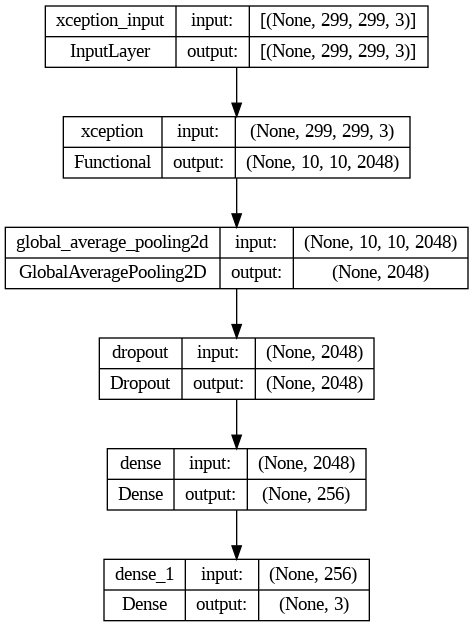

In [42]:
# Plot layers
tf.keras.utils.plot_model(model3, show_shapes=True)

The diagram above illustrates the architecture of the transfer learning model, providing an overview of its structure and components.

After creating the model architecture, the next step is to compile it.

In [43]:
# Compile the model
model3.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.001), metrics=['accuracy'])

The compilation of the model remains consistent with the previous approach.

#### **iii. Model Training**

The model is prepared for training, now with an extended duration of **100** epochs, using both the training and validation datasets.

In [44]:
%%time

# Model training
history3 = model3.fit(train_generator, epochs=100, validation_data=val_generator, callbacks=[early_stopping, lr_scheduler])


Epoch 1: LearningRateScheduler setting learning rate to 0.001.
Epoch 1/100
24/24 [==============================] - 34s 1s/step - loss: 0.6073 - accuracy: 0.7771 - val_loss: 0.3991 - val_accuracy: 0.8606 - lr: 0.0010

Epoch 2: LearningRateScheduler setting learning rate to 0.001.
Epoch 2/100
24/24 [==============================] - 19s 801ms/step - loss: 0.3436 - accuracy: 0.8722 - val_loss: 0.3138 - val_accuracy: 0.8727 - lr: 0.0010

Epoch 3: LearningRateScheduler setting learning rate to 0.001.
Epoch 3/100
24/24 [==============================] - 21s 863ms/step - loss: 0.2935 - accuracy: 0.8814 - val_loss: 0.3555 - val_accuracy: 0.8727 - lr: 0.0010

Epoch 4: LearningRateScheduler setting learning rate to 0.001.
Epoch 4/100
24/24 [==============================] - 19s 794ms/step - loss: 0.2830 - accuracy: 0.8840 - val_loss: 0.3352 - val_accuracy: 0.8606 - lr: 0.0010

Epoch 5: LearningRateScheduler setting learning rate to 0.001.
Epoch 5/100
24/24 [==============================] - 20

The training went through **49** epochs, requiring roughly **16 minutes and 14 seconds** to finish. The final scores for the model were a training loss of **0.1501**, training accuracy of **0.9439**, validation loss of **0.2042**, and validation accuracy of **0.9030**.

In contrast to the previous models, this one may have had a slightly longer training duration due to added epochs, but resulted **significantly better fitting data**. The smaller gap between the training and validation scores suggests that the model generalizes well to unseen data.

#### **iv. Model Evaluation**

To simplify analysis, let's visualize the scores with a line chart to observe how the model progressed during training.

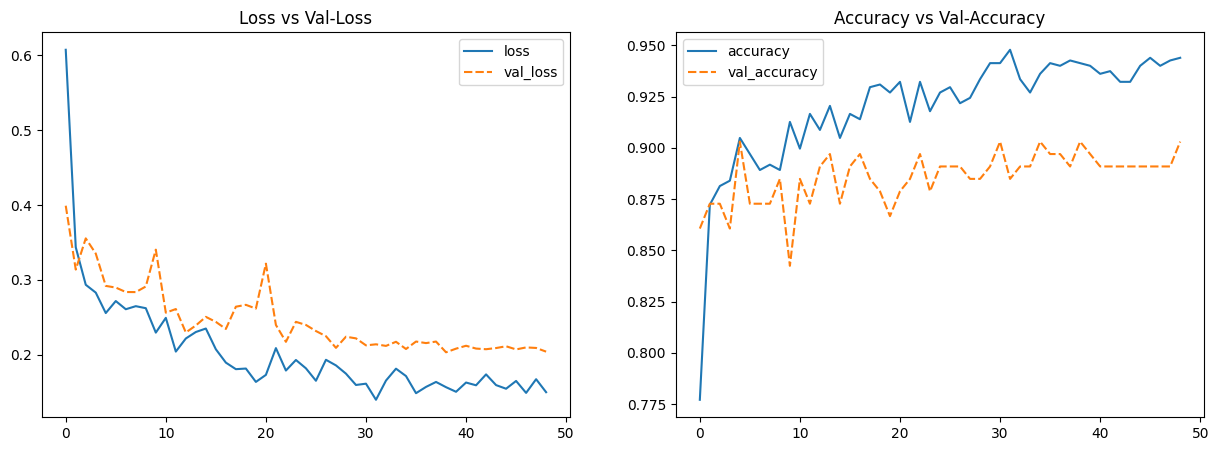

In [45]:
# Plot training results

history_df3 = pd.DataFrame(history3.history)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
sns.lineplot(data=history_df3[['loss', 'val_loss']])
plt.title('Loss vs Val-Loss')

plt.subplot(1, 2, 2)
sns.lineplot(data=history_df3[['accuracy', 'val_accuracy']])
plt.title('Accuracy vs Val-Accuracy')
plt.show()

The graphs display the training and validation loss and accuracy for a machine learning model over 49 epochs:

- **Loss Graph**: The training loss (blue line) decreases steadily, indicating that the model is learning effectively from the training data. The validation loss (orange dashed line) initially follows a similar downward trend but shows variations, with spikes indicating fluctuations in model performance on validation data.

- **Accuracy Graph**: The training accuracy (blue line) rises sharply in the early epochs and then stabilizes at a high level, suggesting consistent learning. In contrast, the validation accuracy (orange dashed line) experiences ups and downs, peaking around the mid epochs before becoming unstable, which may suggest overfitting or the model’s sensitivity to the specific characteristics of the validation data.

These observations suggest that although the model is effectively learning and achieving high accuracy on training data, its performance on validation data is inconsistent, raising concerns about its generalization capabilities. However, this model still represents a significant improvement over the previous ones.

In [46]:
# Check the performance of train-set

# Get the probability predictions
y_pred_prob_train = model3.predict(train_generator)

# Get class with maximum probability
y_pred_class_train = np.argmax(y_pred_prob_train, axis=-1)

# Get the true labels from the train data generator
y_true_train = train_generator.classes

# Get the class names from the training data generator
class_names = list(train_generator.class_indices.keys())

# Display Classification Report
print(classification_report(y_true_train, y_pred_class_train, target_names=class_names))

24/24 [==============================] - 18s 707ms/step
                 precision    recall  f1-score   support

   Benign cases       0.88      0.65      0.75        80
Malignant cases       0.98      0.99      0.99       387
   Normal cases       0.92      0.97      0.95       300

       accuracy                           0.95       767
      macro avg       0.93      0.87      0.89       767
   weighted avg       0.95      0.95      0.95       767



The training performance metrics of the classification model show a high overall accuracy of **95%** across three categories: benign, malignant, and normal cases. Specifically, the model excels in detecting malignant cases with a precision of **0.98** and a recall of **0.99**, resulting in an f1-score of **0.99**. Normal cases are also well-handled, with a precision of **0.92** and a recall of **0.97**, resulting an f1-score of **0.95**. While the accuracy for benign cases is somewhat lower, the model still achieves a decent precision of **0.88** and a recall of **0.65**, reflected in an f1-score of **0.75**.

The high accuracy and f1-scores in these critical categories underscore the model's **effectiveness** in distinguishing between these different medical conditions during training, making it a robust tool for diagnostic purposes.

In [47]:
# Check the performance of test-set

# Get the probability predictions
y_pred_prob3 = model3.predict(test_generator)

# Get class with maximum probability
y_pred_class3 = np.argmax(y_pred_prob3, axis=-1)

# Get the true labels from the test data generator
y_true3 = test_generator.classes

# Get the class names from the training data generator
class_names = list(train_generator.class_indices.keys())

# Display Classification Report
print(classification_report(y_true3, y_pred_class3, target_names=class_names))

6/6 [==============================] - 1s 219ms/step
                 precision    recall  f1-score   support

   Benign cases       0.74      0.64      0.68        22
Malignant cases       1.00      1.00      1.00        87
   Normal cases       0.86      0.91      0.89        56

       accuracy                           0.92       165
      macro avg       0.87      0.85      0.86       165
   weighted avg       0.92      0.92      0.92       165



During the testing phase, the classification model demonstrated strong overall performance with an accuracy of **92%** across 165 cases, including benign, malignant, and normal conditions. The model achieved perfect precision and recall in detecting malignant cases, resulting in a f1-score of **1.00**, which indicates flawless performance in this category. Normal cases also saw strong results with a precision of **0.86** and a recall of **0.91**, leading to an f1-score of **0.89**. Benign cases had the lowest performance metrics, with a precision of **0.74** and a recall of **0.64**, resulting in a f1-score of **0.68**, suggesting some difficulty in accurately identifying these cases compared to others.

Comparing the testing phase accuracy of 92% to the training phase's 95%, the model shows high consistency and reliability across different datasets, which is vital for lung classification. Overall, the model is a **good fit** for its purpose, demonstrating stability and effectiveness in classifying X-ray lung images.

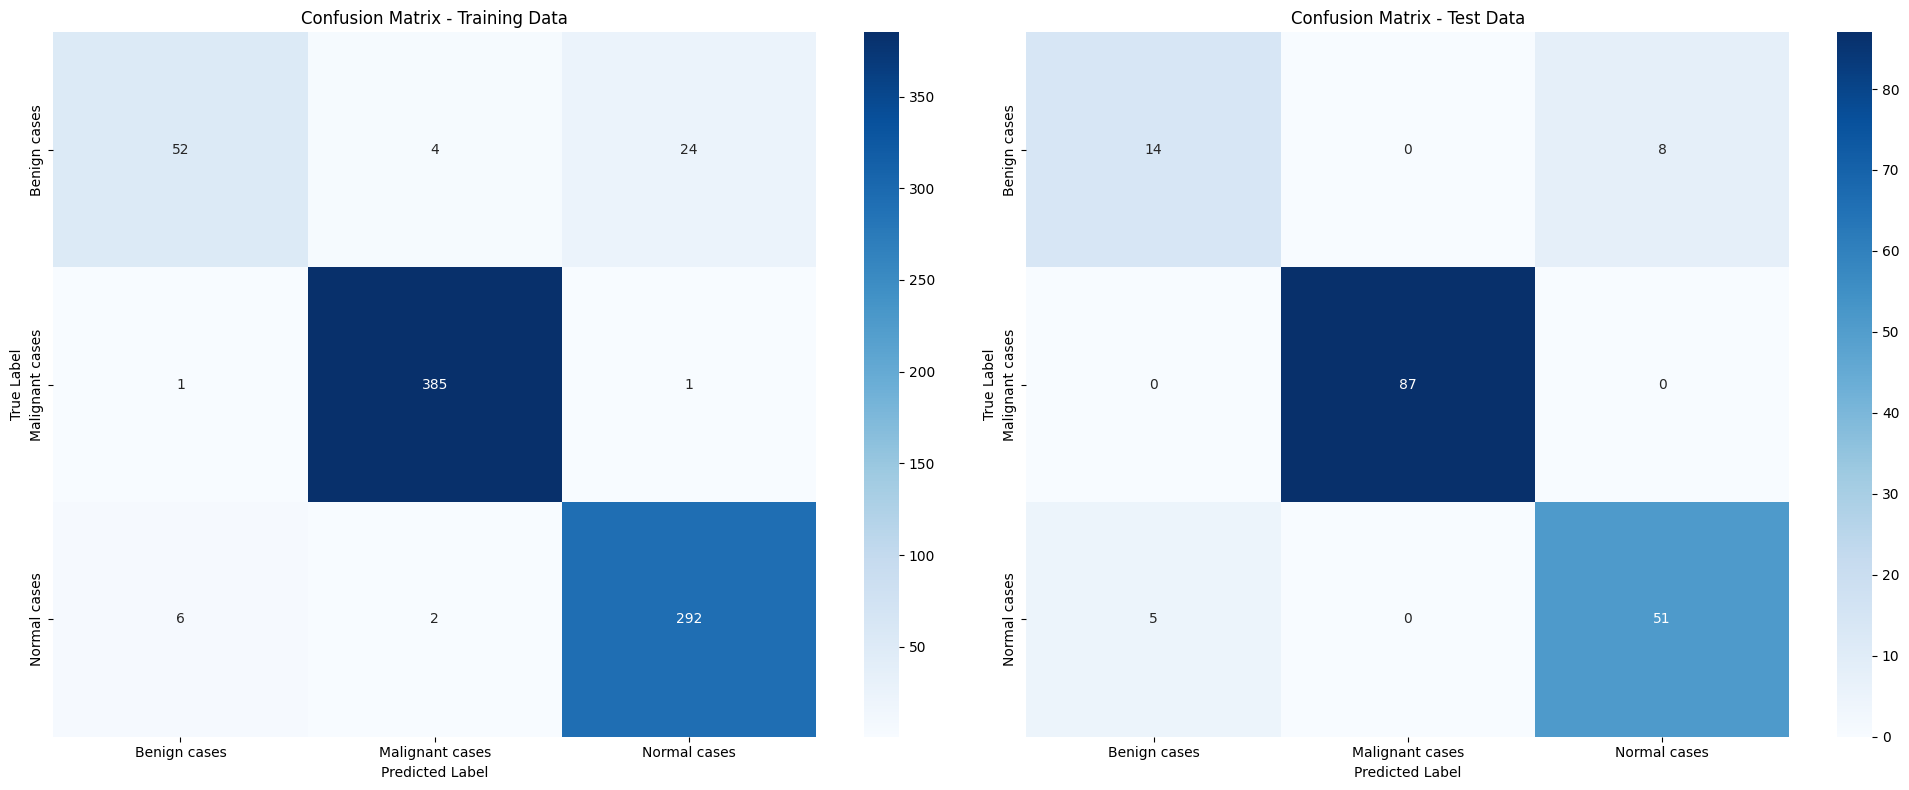

In [48]:
# Generate the confusion matrices
cm_train3 = confusion_matrix(y_true_train, y_pred_class_train)
cm_test3 = confusion_matrix(y_true3, y_pred_class3)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(20, 8))

# Plot confusion matrix for the training data
sns.heatmap(cm_train3, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[0])
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')
axes[0].set_title('Confusion Matrix - Training Data')

# Plot confusion matrix for the test data
sns.heatmap(cm_test3, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names, ax=axes[1])
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')
axes[1].set_title('Confusion Matrix - Test Data')

# Display the plots
plt.tight_layout()
plt.show()

**Training Data:**
- The model performs best in correctly identifying malignant cases with 385 correct predictions out of 387.
- It shows moderate accuracy in recognizing normal cases with 292 correct predictions out of 300.
- Benign cases have the lowest accuracy, with only 52 correct predictions out of 80, indicating significant misclassification.

**Test Data:**
- For malignant cases, the model maintains strong performance, correctly identifying 87 out of 87 cases.
- Normal cases see a slight decline in performance, correctly predicted 51 times out of 56.
- Benign cases continue to be the most challenging for the model, with only 14 correct predictions out of 22, underscoring consistent difficulties in accurately detecting these cases.

Overall, the model exhibits **high accuracy** with malignant and normal cases in both training and testing but **struggles** significantly with benign cases, reflecting a consistent area for potential improvement in model performance.

### **H. Model Saving**

After training three models, it can be concluded that the final model, which uses transfer learning, outperforms the others. As a result, the saved model will be **model3** which is **Sequential Model** with **Transfer Learning**.

In [49]:
# Model summary
model3.trainable = False
model3.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 10, 10, 2048)      20861480  
                                                                 
 global_average_pooling2d (  (None, 2048)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dropout (Dropout)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 3)                 771       
                                                                 
Total params: 21386795 (81.58 MB)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 21386795 (81.58 MB)
______________

The model uses the Xception architecture with **21,386,795** parameters, all of which are non-trainable. The final model size is **81.58 MB**, and it outputs three classes.

In [50]:
# Save the model
model3.save('model3.h5')
model3.save("/content/drive/MyDrive/Hacktive8/P2G7/Model/model3.keras")

The model is saved in both h5 and Keras formats, with backups automatically stored on Google Drive.

### **I. Model Inference**

This section will be performed in a separate file named **'P2G7_livia_amanda_inference.ipynb'**.

### **J. Analysis**

#### **i. EDA**

- **Image Visualizations**: Benign cases show small, smooth spots with no severe damage; malignant cases have irregular, jagged spots with damage; and normal cases have clear lungs with healthy structures.

- **Class Distributions**: The dataset has more images of malignant and normal lung conditions, with 561 and 416 images respectively, compared to only 120 benign cases. This could improve diagnosis of severe conditions but limit understanding of benign ones.

- **Shape Distributions**: The dataset shows a high uniformity in height with a central concentration around 500, while the width measurements are more varied, ranging from 500 to 770, with a primary peak at 520.

- **Color Distributions**: The histogram reveals high-contrast areas with peaks at very dark (75) and very bright (250) regions, helping differentiate between conditions like cancer, benign issues, and normal lungs based on the distribution of mid-tone values.

- **Pixel Intensity Statistics**: The analysis indicates that malignant lung cases have slightly higher mean and median intensities compared to benign and normal cases, though all classes exhibit considerable variability in intensity.



#### **ii. Model Evaluation**

- **Best Model**: The best model is the **sequential Transfer Learning** model with the **Xception** architecture, based on their training, validation, and testing scores. The sequential model is superior because it simplifies the workflow, allowing for **straightforward** layer-by-layer construction and tuning. Transfer learning enhances this by using **pre-trained weights** from the Xception model, which has been trained on an extensive and diverse dataset, thus providing a strong starting point. This combination improves performance significantly compared to standalone sequential or functional models.

- **Training vs Validation**: The model shows a good fit between training and validation loss and accuracy.

- **Metris Evaluation**:
  - Training Set: The training set scores 0.95 for accuracy
  - Testing Set: The testing set scores 0.92 for accuracy.
  - Model Fit: The model represents a good fit between the training set and testing set.

- **Prediction Capability**: The model can predict malignant and normal cases accurately, but it struggles with predicting benign cases.

- **Missclassification**: The model misclassifies benign cases, likely due to the benign dataset being a **minority** class. Benign cases are often misclassified as normal because the differences between these classes are minimal, indicating a need for further improvement.

- **Model Advantages**:

  - **Strong Learning Capability**: The model demonstrates robust learning capabilities, as evidenced by the steady decline in training loss and a significant increase in training accuracy. This suggests that the model effectively captures the underlying patterns and relationships within the training dataset.

  - **High Training Accuracy**: The model achieves high accuracy on the training data, which indicates that it has a good fit to the data it was trained on. This high accuracy is advantageous for scenarios where the training data is representative of the typical use case scenarios.
  
  - **Initial Generalization**: Initially, the validation loss decreases alongside the training loss, suggesting that the model was generalizing well to new data at the beginning of training. This is indicative of a good initial model setup before potential overfitting.
  
- **Model Limitations**:

   - **Validation Performance Fluctuations**: The validation loss and accuracy show considerable fluctuations and do not stabilize like the training metrics. This could indicate issues with the model's ability to generalize to unseen data consistently, which is critical for practical applications.

   - **Possible Overfitting**: The divergence between training and validation accuracy, particularly where validation accuracy peaks and then declines, suggests that the model may be overfitting. Overfitting occurs when a model learns details and noise in the training data to an extent that it negatively impacts the performance of the model on new data.
   
   - **Model Sensitivity**: The ups and downs in the validation loss graph might show that the model is sensitive to the unique traits of the validation dataset. This could be a problem if the validation set has unusual features that the model wasn't trained to handle.

#### **iii. Model Improvement**

- **Imbalance Data Handling:** The dataset currently has a minimal number of benign cases, which contributes to the lower performance scores. To address this, techniques like SMOTE should be used to balance the number of instances in each class, thereby improving the model's accuracy.

- **Transfer Learning with Other Models:** Experiment with other advanced models such as **EfficientNetB7**, which is known for its high performance in image classification tasks. This could potentially lead to better results than the current model.
  
- **Preprocess Images:** Implementing additional image preprocessing techniques, such as **contrast enhancement** and **edge detection**, which can help make the features more distinguishable, thereby making it easier for the model to accurately predict the cases.
  
- **Model Architecture:** Explore different model architectures, such as combining transfer learning with the Functional API, to potentially enhance the model's ability to learn and generalize from the data. This approach might offer improvements over the current sequential model setup.

- **Expand the Dataset**: Consider acquiring additional data for benign cases to achieve a more balanced dataset.

#### **iv. Bussiness Insights**

- **Healthcare Impact**: The model can significantly enhance diagnostic processes in healthcare settings by providing quick and accurate classifications of lung conditions. This capability leads to faster treatment decisions and could improve patient outcomes, especially in environments where access to radiologists is limited.

- **Scalability and Integration**: There is potential to integrate the model into existing health IT systems across hospitals and clinics to streamline workflows and increase the efficiency of radiological diagnostics. Integration could extend to telehealth platforms, enhancing accessibility.

- **Commercial Partnerships**: The technology may attract partnerships with medical technology companies or collaborations with healthcare providers, facilitating widespread adoption and driving advancements through additional funding and research.

This development positions the model well within the growing field of AI in healthcare, offering a blend of technological innovation and significant potential for positive healthcare outcomes.

### **K. Conclusion**

The **sequential** model that utilizes **Transfer Learning** with **Xception** outperforms other models, demonstrating a **good fit** with a training accuracy of **0.95** and a testing accuracy of **0.92**. While this model is capable of classifying X-ray images into malignant, benign, or normal lung conditions, there is room for further enhancements to improve its overall accuracy.